# 08. Milestone PyTorch Paper Replicating 

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) architecture/paper with PyTorch.

See ground truth notebook [here](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

## 0. Get setup

Let's import code we're previously written + required libraries.

In [1]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.0.1+cu117', '0.15.2+cu117')

In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine

In [3]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steat, susui images we've been using so far.

In [4]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [6]:
from going_modular import data_setup


# Create image size
IMG_SIZE = 224  # comes from tabel 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(F"Manually creaded transform {manual_transforms}")

Manually creaded transform Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize*!

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

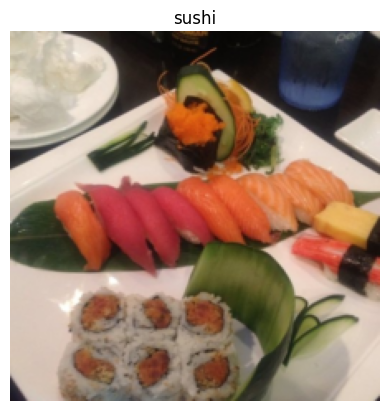

In [14]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # [channel, height, width] -> [height, width, channel]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole mechine learning paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs**: What goes into the model? (in our case, image tensors)
* **Outputs**: What comes out of model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers**: Take an input, manipulate it with a function (for example could be self-attention).
* **Block**: A collection of layers.
* **Model**: A collection of blocks.

### 3.1 ViT overview: pieces of puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training.
* Text

### Figure 1

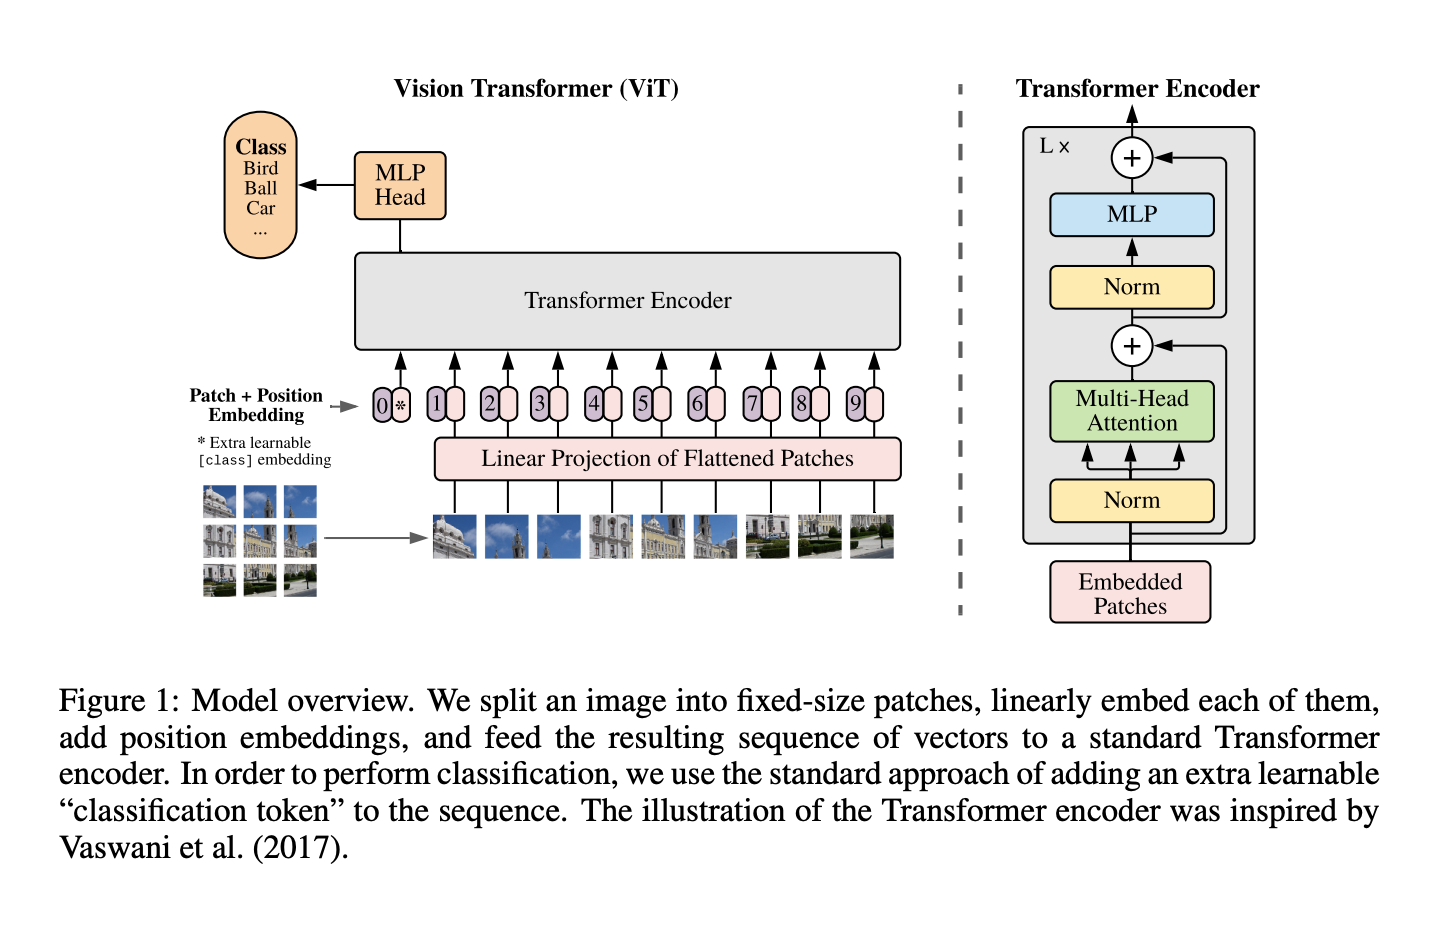

* Embedding = label represtation (start with random numbers and improve over time)

### Four equations

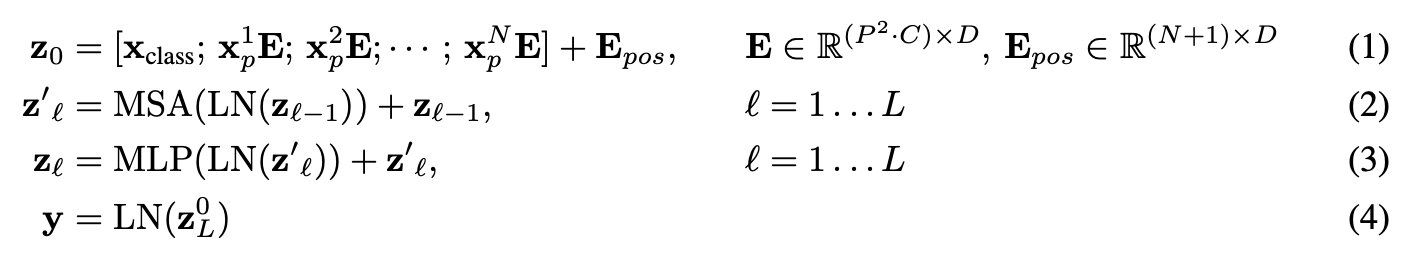

### Table 1/3

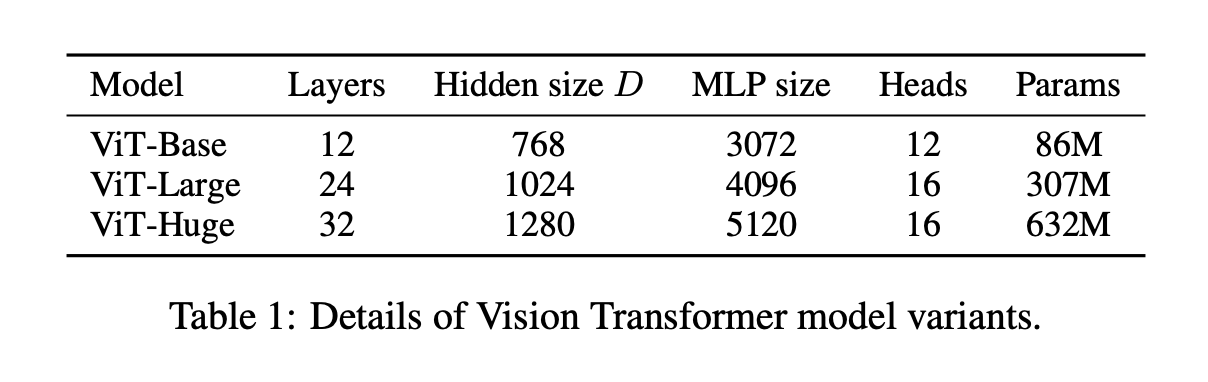
